In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:

def compute_cost(X, y, theta):
    m = len(y)
    predictions = X @ theta
    error = predictions - y
    return (1 / (2 * m)) * np.sum(error ** 2)


def compute_cost_l2(X, y, theta, lmbd):
    m = len(y)
    predictions = X @ theta
    error = predictions - y
    theta_no_bias = theta[1:]
    l2_term = (lmbd / (2 * m)) * np.sum(theta_no_bias ** 2)
    return (1 / (2 * m)) * np.sum(error ** 2) + l2_term


def gradient_descent(X_train, y_train, X_val, y_val, theta, alpha, iterations):
    m = len(y_train)
    train_cost_history = []
    val_cost_history = []
    for _ in range(iterations):
        predictions = X_train @ theta
        error = predictions - y_train
        gradient = (1 / m) * (X_train.T @ error)
        theta -= alpha * gradient
        train_cost_history.append(compute_cost(X_train, y_train, theta))
        val_cost_history.append(compute_cost(X_val, y_val, theta))
    return theta, train_cost_history, val_cost_history


def gradient_descent_l2(X_train, y_train, X_val, y_val, theta, alpha, iterations, lmbd):
    m = len(y_train)
    train_cost_history = []
    val_cost_history = []
    for _ in range(iterations):
        predictions = X_train @ theta
        error = predictions - y_train
        gradient = (1 / m) * (X_train.T @ error)
        gradient[1:] += (lmbd / m) * theta[1:]  # Regularize all but bias
        theta -= alpha * gradient
        train_cost_history.append(compute_cost_l2(X_train, y_train, theta, lmbd))
        val_cost_history.append(compute_cost(X_val, y_val, theta))
    return theta, train_cost_history, val_cost_history

def preprocess_binary(values, true_word, false_word):
    return np.array([1 if val == true_word else 0 for val in values])


def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])


def normalize_train_val(X_train, X_val):
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    return (X_train - X_min) / (X_max - X_min + 1e-8), (X_val - X_min) / (X_max - X_min + 1e-8)

def standardize_train_val(X_train, X_val):
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0)
    return (X_train - X_mean) / (X_std + 1e-8), (X_val - X_mean) / (X_std + 1e-8)


def train_val_split(X, y, seed=42, train_ratio=0.8):
    np.random.seed(seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split = int(train_ratio * len(indices))
    train_idx, val_idx = indices[:split], indices[split:]
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]


In [3]:

def run_training(X_raw, y, alpha_list, iterations=300, scaling=None, use_l2=False, lmbd=0.1, title=""):
    X_train, y_train, X_val, y_val = train_val_split(X_raw, y)

    if scaling == 'normalize':
        X_train, X_val = normalize_train_val(X_train, X_val)
    elif scaling == 'standardize':
        X_train, X_val = standardize_train_val(X_train, X_val)

    X_train = add_bias(X_train)
    X_val = add_bias(X_val)

    best_val_loss = float('inf')
    best_theta = None
    best_alpha = None

    plt.figure()
    for alpha in alpha_list:
        theta = np.zeros(X_train.shape[1])
        if use_l2:
            theta, train_loss, val_loss = gradient_descent_l2(X_train, y_train, X_val, y_val, theta, alpha, iterations, lmbd)
        else:
            theta, train_loss, val_loss = gradient_descent(X_train, y_train, X_val, y_val, theta, alpha, iterations)

        plt.plot(train_loss, label=f'Train α={alpha}')
        plt.plot(val_loss, label=f'Val α={alpha}', linestyle='--')

        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            best_theta = theta
            best_alpha = alpha

    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title + f" | {'L2' if use_l2 else 'No Reg'} | Scaling: {scaling or 'None'}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Best alpha:", best_alpha)
    print("Best validation loss:", best_val_loss)
    print("Best theta:", best_theta)
    print("=" * 50)



In [4]:


df = pd.read_csv("Housing.csv")
price = df.values[:, 0].astype(float)
area = df.values[:, 1].astype(float)
bedrooms = df.values[:, 2].astype(float)
bathrooms = df.values[:, 3].astype(float)
stories = df.values[:, 4].astype(float)

mainroad = preprocess_binary(df.values[:, 5], 'yes', 'no')
guestroom = preprocess_binary(df.values[:, 6], 'yes', 'no')
basement = preprocess_binary(df.values[:, 7], 'yes', 'no')
hotwaterheating = preprocess_binary(df.values[:, 8], 'yes', 'no')
airconditioning = preprocess_binary(df.values[:, 9], 'yes', 'no')
parking = df.values[:, 10].astype(float)
prefarea = preprocess_binary(df.values[:, 11], 'yes', 'no')
furnishing_map = {'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0}
furnishingstatus = np.array([furnishing_map[val] for val in df.values[:, 12]])


X_5feat = np.column_stack([area, bedrooms, bathrooms, stories, parking])
X_11feat = np.column_stack([
    area, bedrooms, bathrooms, stories, mainroad, guestroom,
    basement, hotwaterheating, airconditioning, parking, prefarea
])
Y = price


/tmp/ipykernel_56558/3460745883.py:5: RuntimeWarning: overflow encountered in square
  return (1 / (2 * m)) * np.sum(error ** 2)
/tmp/ipykernel_56558/3460745883.py:24: RuntimeWarning: overflow encountered in matmul
  gradient = (1 / m) * (X_train.T @ error)
/tmp/ipykernel_56558/3460745883.py:24: RuntimeWarning: invalid value encountered in matmul
  gradient = (1 / m) * (X_train.T @ error)
/tmp/ipykernel_56558/3460745883.py:25: RuntimeWarning: invalid value encountered in subtract
  theta -= alpha * gradient


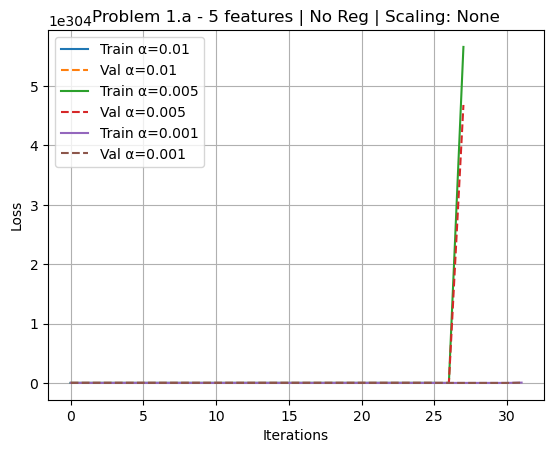

Best alpha: None
Best validation loss: inf
Best theta: None


In [5]:

run_training(X_5feat, Y, alpha_list=[0.01, 0.005, 0.001], scaling=None, use_l2=False, title="Problem 1.a - 5 features")


/tmp/ipykernel_56558/3460745883.py:5: RuntimeWarning: overflow encountered in square
  return (1 / (2 * m)) * np.sum(error ** 2)
/tmp/ipykernel_56558/3460745883.py:24: RuntimeWarning: overflow encountered in matmul
  gradient = (1 / m) * (X_train.T @ error)
/tmp/ipykernel_56558/3460745883.py:24: RuntimeWarning: invalid value encountered in matmul
  gradient = (1 / m) * (X_train.T @ error)
/tmp/ipykernel_56558/3460745883.py:25: RuntimeWarning: invalid value encountered in subtract
  theta -= alpha * gradient


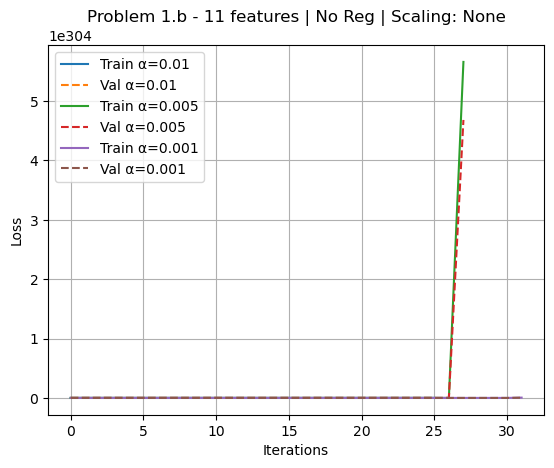

Best alpha: None
Best validation loss: inf
Best theta: None


In [6]:
run_training(X_11feat, Y, alpha_list=[0.01, 0.005, 0.001], scaling=None, use_l2=False, title="Problem 1.b - 11 features")


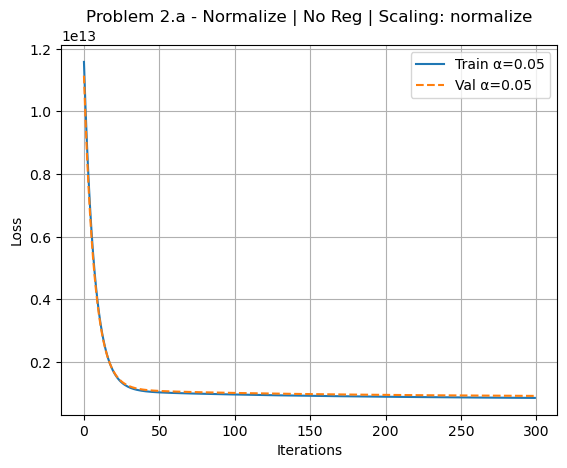

Best alpha: 0.05
Best validation loss: 914789510001.5039
Best theta: [2741525.00376411 1894561.72333687 1393377.22078436 1752704.85454135
 1647842.57831107 1440884.63789266]


In [7]:
run_training(X_5feat, Y, alpha_list=[0.05], scaling='normalize', use_l2=False, title="Problem 2.a - Normalize")


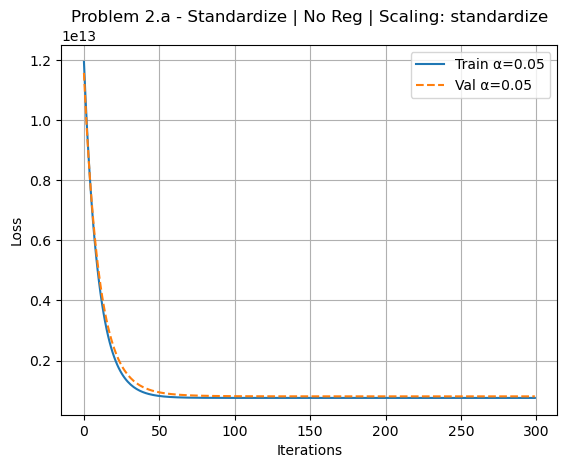

Best alpha: 0.05
Best validation loss: 809659397828.79
Best theta: [4788864.6942385   708603.47602057  129574.5089913   567906.06238621
  521644.1502452   316306.47695305]


In [8]:
run_training(X_5feat, Y, alpha_list=[0.05], scaling='standardize', use_l2=False, title="Problem 2.a - Standardize")
